# start

http://localhost:8081/notebooks/git/recsys20/working/Reply0411_1_optuna_tuningfeature_params_1e6-ran00-0.1046-11.7583.ipynb

In [13]:
TGT='Reply'
PRFX='Reply0411_2'

trntmstmp=1584412344
tsttmstmp=1586133347

tm_trn_min,tm_trn_max=(1580947200, 1581551999)
tm_tst_min,tm_tst_max=(1581552000, 1582156799)

SEED=101

valsz = int(4e7)#int(1e5)
trnsz = int(1e6)#int(5e5)

train_total=148075238
test_total=int(1.4e7)
print(f'train_total {train_total:,}, test_total {test_total:,}')


import datetime
def showtm(tm): return datetime.datetime.fromtimestamp(tm).strftime('%Y-%m-%d %H:%M:%S')
print([showtm(tm) for tm in (trntmstmp, tsttmstmp)])
print([showtm(tm) for tm in (tm_trn_min,tm_trn_max)])
print([showtm(tm) for tm in (tm_tst_min,tm_tst_max)])

train_total 148,075,238, test_total 14,000,000
['2020-03-17 02:32:24', '2020-04-06 00:35:47']
['2020-02-06 00:00:00', '2020-02-12 23:59:59']
['2020-02-13 00:00:00', '2020-02-19 23:59:59']


# setup

In [14]:
from tqdm import tqdm
import time
from pathlib import Path
from collections import Counter,defaultdict
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc, precision_recall_curve
import pickle
# import xgboost as xgb
import lightgbm as lgb
import category_encoders as ce
import gc

# import optuna
# optuna.logging.CRITICAL, optuna.logging.FATAL
# optuna.logging.ERROR
# optuna.logging.WARNING, optuna.logging.WARN
# optuna.logging.INFO
# optuna.logging.DEBUG
# optuna.logging.set_verbosity(optuna.logging.ERROR)
# import optuna.integration.lightgbm as lgb
# optuna.logging.disable_default_handler()


pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)


import datetime
def dtnow(): return datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')

def iou(s1,s2):
    return len(s1&s2) / len(s1|s2)

HOME='/data/git/recsys20'
p_in=f'{HOME}/input'
p_out=f'{HOME}/output/{PRFX}'
Path(p_out).mkdir(exist_ok=True, parents=True)

from sklearn.metrics import precision_recall_curve, auc, log_loss

def compute_prauc(pred, gt):
    prec, recall, thresh = precision_recall_curve(gt, pred)
    prauc = auc(recall, prec)
    return prauc

def calculate_ctr(gt):
    positive = len([x for x in gt if x == 1])
    ctr = positive/float(len(gt))
    return ctr

def compute_rce(pred, gt):
    cross_entropy = log_loss(gt, pred)
    data_ctr = calculate_ctr(gt)
    strawman_cross_entropy = log_loss(gt, [data_ctr for _ in range(len(gt))])
    return (1.0 - cross_entropy/strawman_cross_entropy)*100.0

# https://towardsdatascience.com/how-to-calibrate-undersampled-model-scores-8f3319c1ea5b
# How to use the function?
# Let’s say your goal is to generate a model that shows the credit default probabilities and your original 
# training data has 50,000 rows with only 500 of them labeled as target class. When you sample your non-target 
# instances randomly and reduce the total row count to 10,000, while conserving 500 target rows, our calibration
# function becomes:
# calibration(model_results, 50000, 500, 10000, 500)
# Here model_results is your model probability output array. After you train your model and put the results in it, your function is ready to use. 
def calibration(data, train_pop, target_pop, sampled_train_pop, sampled_target_pop):
    calibrated_data = ((data * (target_pop / train_pop) / (sampled_target_pop / sampled_train_pop)) /
    (((1 - data) * (1 - target_pop / train_pop) / (1 - sampled_target_pop / sampled_train_pop)) +
     (data * (target_pop / train_pop) / (sampled_target_pop / sampled_train_pop))))
    return calibrated_data


cols=['toks','hshtgs','twtid','media','links','domns','twttyp','lang','tm','u1id','u1_fllwer_cnt','u1_fllwing_cnt','u1_vrfed','u1_create_tm','u2id','u2_fllwer_cnt','u2_fllwng_cnt','u2_vrfed','u2_create_tm','u1_fllw_u2','reply_tm','retwt_tm','retwt_cmmnt_tm','like_tm',]

cols_val = cols[:-4]
cols_tgt_tmstmp=[ 'retwt_tm', 'reply_tm', 'like_tm', 'retwt_cmmnt_tm',]
cols_tgt=[o.split('_tm')[0] for o in cols_tgt_tmstmp]
tgts             = ['Retweet','Reply','Like','RTwCmnt',]
assert cols_tgt == ['retwt',  'reply','like','retwt_cmmnt',]
tgt2col = dict(zip(tgts, cols_tgt))
TCOL=tgt2col[TGT]
print('TCOL', TCOL)
print(tgt2col)

TCOL reply
{'Retweet': 'retwt', 'Reply': 'reply', 'Like': 'like', 'RTwCmnt': 'retwt_cmmnt'}


# prep

In [15]:
def prp_tgt(df):
    df[cols_tgt]=df[cols_tgt_tmstmp].notna()
    df.drop(columns=cols_tgt_tmstmp, inplace=True)
    display(df[cols_tgt].mean())

In [16]:
%%time
dfval = pd.read_csv(f'{p_in}/trn_{trntmstmp}.tsv',sep='\x01',header=None,names=cols,nrows=valsz)
print(dfval.shape)
prp_tgt(dfval)

KeyboardInterrupt: 

## maybe oversample

In [17]:
# df = pd.read_csv(f'{p_in}/trn_{trntmstmp}.tsv',sep='\x01',header=None,names=cols,nrows=5)
# dfval = pd.read_csv(f'{p_in}/trn_{trntmstmp}.tsv',sep='\x01',header=None,names=cols,nrows=2)
# dftrn = pd.read_csv(f'{p_in}/trn_{trntmstmp}.tsv',sep='\x01',header=None,names=cols,skiprows=2,nrows=3)
# display(df.twtid)
# display(dfval.twtid)
# display(dftrn.twtid)

# 0    D4D1EBDE74F74C5DA529959AF979625C
# 1    BFB529DAB6D384EB83E899A72AB3830D
# 2    519078C7834E9642508F72A6C2D0F3B7
# 3    52AAE9E33EFAC8C478C57B31A9E31ED1
# 4    89C1298C55EB3D68E2784F0BFB69E6F8
# Name: twtid, dtype: object
# 0    D4D1EBDE74F74C5DA529959AF979625C
# 1    BFB529DAB6D384EB83E899A72AB3830D
# Name: twtid, dtype: object
# 0    519078C7834E9642508F72A6C2D0F3B7
# 1    52AAE9E33EFAC8C478C57B31A9E31ED1
# 2    89C1298C55EB3D68E2784F0BFB69E6F8
# Name: twtid, dtype: object

In [ ]:
%%time
if TGT in ('Retweet','Like'): trnpop=trnsz
if TGT=='Reply': trnpop=trnsz*3.7
if TGT=='RTwCmnt': trnpop=trnsz*11.5
assert trnpop<train_total

dftrn = pd.read_csv(f'{p_in}/trn_{trntmstmp}.tsv',sep='\x01',header=None,names=cols,
                     skiprows=valsz, nrows=trnpop)
print(dftrn.shape)
prp_tgt(dftrn)

In [ ]:
train_pop=len(dftrn)
sampled_train_pop=trnsz
idx_pos = np.where(dftrn[TCOL])[0]
target_pop=sampled_target_pop=len(idx_pos)
if TGT in ('Reply','RTwCmnt'):
    idx_neg0 = np.where(~dftrn[TCOL])[0]
    idx_neg = np.random.choice(idx_neg0, trnsz-len(idx_pos), replace=False)
    idx = np.concatenate([idx_pos,idx_neg])
    dftrn = dftrn.iloc[idx].copy()
print(dftrn.shape, dftrn[TCOL].mean())
print(train_pop, target_pop, sampled_train_pop, sampled_target_pop)

display(dftrn.head())
display(dftrn.columns)

## prep and features

In [ ]:
def prp_df(df, tm_max):
    '''
    tm_max = tm_trn_max for train tm_tst_max for test
    '''
    lendf = len(df)
    print(dtnow(), 'start')
    set_u1 = set(df.u1id)
    set_u2 = set(df.u2id)
    df['u1inu2']=df.u1id.isin(set_u2)
    df['u2inu1']=df.u2id.isin(set_u1)

    #counts
    df['len_toks'] = df.toks.apply(lambda x: len(x.split('\t')))
    df.drop(columns=['toks'], inplace=True)    
    for m in ['Photo', 'Video', 'GIF']:
        df[f'n_media_{m}'] = df['media'].fillna('').apply(lambda x: x.split('\t').count(m))
    tgnms = ['hshtgs','media', 'links', 'domns',]
    for tgnm in tgnms:
        df[f'has_{tgnm}']=df[tgnm].notna()
        df[f'lst_{tgnm}'] = df[tgnm].fillna('').apply(lambda x: x.split('\t') if len(x) else [])
        df[f'n_{tgnm}'] = df[f'lst_{tgnm}'].apply(len)  
    df.drop(columns=['has_links','n_links'], inplace=True) #duplicates has_domns,n_domns 
    
    #time
    dt = pd.to_datetime(df.tm, unit='s')
    df['dayofweek'] = dt.dt.dayofweek
    df['hour'] = dt.dt.hour
    
    df['tmdlta_u2u1']  = df.u2_create_tm - df.u1_create_tm
    df['tmdlta_twtu1'] = df.tm - df.u1_create_tm
    df['tmdlta_twtu2'] = df.tm - df.u2_create_tm

    df['twt_age']   = tm_max-df.tm
    df['u1_age']    = tm_max-df.u1_create_tm
    df['u2_age']    = tm_max-df.u2_create_tm
    df.drop(columns=['tm', 'u1_create_tm', 'u2_create_tm'], inplace=True)

    #time derived
    df['u1_fllwer_cnt_by_age'] = df.u1_fllwer_cnt / df.u1_age
    df['u1_fllwng_cnt_by_age'] = df.u2_fllwng_cnt / df.u2_age
    
    #interaction
    df['u1u2']=df.u1id+'_'+df.u2id
    df['langhour']=df.lang+'_'+df.hour.astype(str)
    

    #freq of feature values
    print(dtnow(), 'freq of columns using CountEncoder')
    encoder = ce.CountEncoder()
    encoded = encoder.fit_transform(
    df[['twtid', 'twttyp', 'lang', 'u1id', 'u1_fllwing_cnt', 'u1_vrfed', 'u2id', 'u2_fllwer_cnt', 'u2_vrfed', 'u1_fllw_u2', 
       'n_media_Photo', 'n_media_Video', 'n_media_GIF', 
       'has_hshtgs', 'n_hshtgs', 'has_media', 'n_media','has_domns', 'n_domns', 
       'dayofweek', 'hour', 'u1u2', 'langhour']].astype(object))
    encoded = encoded.astype(int)/lendf
    encoded.columns = [f'frq_{col}' for col in encoded.columns]
    df = pd.concat([df,encoded],1)
    
    #freq of tgnm values
    print(dtnow(), 'freq of tags')
    for tgnm in tgnms:
        vs = [j for i in df[f'lst_{tgnm}'] for j in i]
        cnt = Counter(vs)
        frq = {k:v/lendf for k,v in cnt.items()}
        df[f'sumfrq_{tgnm}']=df[f'lst_{tgnm}'].apply(lambda x: sum([frq.get(o,0) for o in x]))
        df[f'maxfrq_{tgnm}']=df[f'lst_{tgnm}'].apply(lambda x: max([frq.get(o,0) for o in x]) if len(x) else 0)
    df.drop(columns=tgnms+[f'lst_{tgnm}' for tgnm in tgnms],inplace=True)

    print(dtnow(), 'done')
    return df

In [ ]:
%%time
dftrn=prp_df(dftrn, tm_max=tm_trn_max)

In [ ]:
%%time
dfval=prp_df(dfval, tm_max=tm_trn_max)

## tr vl split and target encoding

In [11]:
msk_vl=np.random.rand(len(dftrn))<0.15
idxvl=np.where( msk_vl)[0]
idxtr=np.where(~msk_vl)[0]

dftr = dftrn.iloc[idxtr].copy()
dfvl = dftrn.iloc[idxvl].copy()
del dftrn

gc.collect()

30

In [12]:
dftr.columns

Index(['twtid', 'twttyp', 'lang', 'u1id', 'u1_fllwer_cnt', 'u1_fllwing_cnt',
       'u1_vrfed', 'u2id', 'u2_fllwer_cnt', 'u2_fllwng_cnt', 'u2_vrfed',
       'u1_fllw_u2', 'retwt', 'reply', 'like', 'retwt_cmmnt', 'u1inu2',
       'u2inu1', 'len_toks', 'n_media_Photo', 'n_media_Video', 'n_media_GIF',
       'has_hshtgs', 'n_hshtgs', 'has_media', 'n_media', 'has_domns',
       'n_domns', 'dayofweek', 'hour', 'tmdlta_u2u1', 'tmdlta_twtu1',
       'tmdlta_twtu2', 'twt_age', 'u1_age', 'u2_age', 'u1_fllwer_cnt_by_age',
       'u1_fllwng_cnt_by_age', 'u1u2', 'langhour', 'frq_twtid', 'frq_twttyp',
       'frq_lang', 'frq_u1id', 'frq_u1_fllwing_cnt', 'frq_u1_vrfed',
       'frq_u2id', 'frq_u2_fllwer_cnt', 'frq_u2_vrfed', 'frq_u1_fllw_u2',
       'frq_n_media_Photo', 'frq_n_media_Video', 'frq_n_media_GIF',
       'frq_has_hshtgs', 'frq_n_hshtgs', 'frq_has_media', 'frq_n_media',
       'frq_has_domns', 'frq_n_domns', 'frq_dayofweek', 'frq_hour', 'frq_u1u2',
       'frq_langhour', 'sumfrq_hshtgs', 

In [13]:
%%time
col2tgtenc=['twtid', 'twttyp', 'lang', 'u1id', 'u1_fllwing_cnt', 'u1_vrfed', 'u2id', 'u2_fllwer_cnt', 'u2_vrfed', 'u1_fllw_u2', 
   'n_media_Photo', 'n_media_Video', 'n_media_GIF', 
   'has_hshtgs', 'n_hshtgs', 'has_media', 'n_media','has_domns', 'n_domns', 
   'dayofweek', 'hour', 'u1u2', 'langhour']
tgt_encoder = ce.TargetEncoder()
encoded_tr = tgt_encoder.fit_transform(dftr[col2tgtenc].astype(object), dftr[TCOL])
encoded_vl = tgt_encoder.transform(dfvl[col2tgtenc].astype(object))
encoded_val = tgt_encoder.transform(dfval[col2tgtenc].astype(object))

tgtenc_columns = [f'tgtenc_{col}' for col in encoded_tr.columns]
encoded_tr.columns = tgtenc_columns
encoded_vl.columns = tgtenc_columns
encoded_val.columns = tgtenc_columns

dftr = pd.concat([dftr, encoded_tr], 1)
dfvl = pd.concat([dfvl, encoded_vl], 1)
dfval = pd.concat([dfval, encoded_val], 1)


CPU times: user 1min 15s, sys: 16.4 s, total: 1min 32s
Wall time: 1min 36s


In [14]:
cols_category=['twttyp', 'lang', 'langhour']
for df in dftr,dfvl,dfval:
    df.drop(columns=['twtid','u1id','u2id','u1u2'], inplace=True)
    df[cols_category]=df[cols_category].astype('category')

In [15]:
cols_feat = [col for col in dftr.columns if col not in cols_tgt]

# model

## cols_feat

In [16]:
print(len(cols_feat))
cols_feat=['twttyp',
 'lang',
 'u1_fllwer_cnt',
 'u1_fllwing_cnt',
 'u1_vrfed',
 'u2_fllwer_cnt',
 'u2_fllwng_cnt',
 'u2_vrfed',
 'u1_fllw_u2',
 'u1inu2',
 'u2inu1',
 'len_toks',
 'n_media_Photo',
 'n_media_Video',
 'n_media_GIF',
#  'has_hshtgs',
 'n_hshtgs',
#  'has_media',
 'n_media',
#  'has_domns',
 'n_domns',
 'dayofweek',
 'hour',
 'tmdlta_u2u1',
 'tmdlta_twtu1',
 'tmdlta_twtu2',
 'twt_age',
 'u1_age',
 'u2_age',
 'u1_fllwer_cnt_by_age',
 'u1_fllwng_cnt_by_age',
 'langhour',
 'frq_twtid',
#  'frq_twttyp',
#  'frq_lang',
 'frq_u1id',
#  'frq_u1_fllwing_cnt',
#  'frq_u1_vrfed',
 'frq_u2id',
#  'frq_u2_fllwer_cnt',
#  'frq_u2_vrfed',
#  'frq_u1_fllw_u2',
#  'frq_n_media_Photo',
#  'frq_n_media_Video',
#  'frq_n_media_GIF',
#  'frq_has_hshtgs',
#  'frq_n_hshtgs',
#  'frq_has_media',
#  'frq_n_media',
#  'frq_has_domns',
#  'frq_n_domns',
#  'frq_dayofweek',
#  'frq_hour',
 'frq_u1u2',
#  'frq_langhour',
 'sumfrq_hshtgs',
#  'maxfrq_hshtgs',
#  'sumfrq_media',
#  'maxfrq_media',
#  'sumfrq_links',
#  'maxfrq_links',
 'sumfrq_domns',
#  'maxfrq_domns',
#  'tgtenc_twtid',
#  'tgtenc_twttyp',
 'tgtenc_lang',
#  'tgtenc_u1id',
#  'tgtenc_u1_fllwing_cnt',
#  'tgtenc_u1_vrfed',
#  'tgtenc_u2id',
#  'tgtenc_u2_fllwer_cnt',
#  'tgtenc_u2_vrfed',
#  'tgtenc_u1_fllw_u2',
#  'tgtenc_n_media_Photo',
#  'tgtenc_n_media_Video',
#  'tgtenc_n_media_GIF',
#  'tgtenc_has_hshtgs',
#  'tgtenc_n_hshtgs',
#  'tgtenc_has_media',
#  'tgtenc_n_media',
#  'tgtenc_has_domns',
#  'tgtenc_n_domns',
#  'tgtenc_dayofweek',
#  'tgtenc_hour',
#  'tgtenc_u1u2',
#  'tgtenc_langhour'
          ]
print(len(cols_feat))

86
36


In [17]:
results = {}
results['PRFX'] = PRFX
results['TGT'] = TGT
results['cols_feat'] = cols_feat
results['tgt_encoder'] = tgt_encoder
results['col2tgtenc'] = col2tgtenc

In [18]:
params={
    'objective': 'binary',
    'metric': 'binary_logloss',
    'verbosity': 0,    
}
results['params'] = params

In [19]:
%%time
dtr = lgb.Dataset(dftr[cols_feat], label=dftr[TCOL])
dvl = lgb.Dataset(dfvl[cols_feat], label=dfvl[TCOL])
best_params, tuning_history = {}, []
evalres = {}
evallist = [(dtr, 'train'), (dvl, 'eval')]
bst = lgb.train(params=params, 
                train_set=dtr, 
                num_boost_round=50000,
                valid_sets=[dtr, dvl],
                valid_names=['tr','vl'],
                best_params=best_params,
                tuning_history=tuning_history,
                verbose_eval=100,
                early_stopping_rounds=100,
                evals_result=evalres,
               )
results['bst'] = bst
results['evalres'] = evalres
results['best_params']=best_params
results['tuning_history']=tuning_history

/data/anaconda3/envs/rcss20/lib/python3.7/site-packages/optuna/_experimental.py:87: ExperimentalWarning: train is experimental (supported from v0.18.0). The interface can change in the future.
  ExperimentalWarning
tune_feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.275174	vl's binary_logloss: 0.281326
[200]	tr's binary_logloss: 0.270986	vl's binary_logloss: 0.280767
[300]	tr's binary_logloss: 0.26788	vl's binary_logloss: 0.280507
[400]	tr's binary_logloss: 0.265157	vl's binary_logloss: 0.280324
[500]	tr's binary_logloss: 0.262406	vl's binary_logloss: 0.280287
[600]	tr's binary_logloss: 0.259898	vl's binary_logloss: 0.280247
[700]	tr's binary_logloss: 0.257498	vl's binary_logloss: 0.280282
Early stopping, best iteration is:
[626]	tr's binary_logloss: 0.259273	vl's binary_logloss: 0.280194


tune_feature_fraction, val_score: 0.280194:  14%|#4        | 1/7 [00:52<05:14, 52.34s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.274777	vl's binary_logloss: 0.281407
[200]	tr's binary_logloss: 0.270245	vl's binary_logloss: 0.280826
[300]	tr's binary_logloss: 0.266641	vl's binary_logloss: 0.280576
[400]	tr's binary_logloss: 0.263568	vl's binary_logloss: 0.280457
Early stopping, best iteration is:
[386]	tr's binary_logloss: 0.264043	vl's binary_logloss: 0.280436


tune_feature_fraction, val_score: 0.280194:  29%|##8       | 2/7 [01:33<04:05, 49.06s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.273824	vl's binary_logloss: 0.281284
[200]	tr's binary_logloss: 0.269073	vl's binary_logloss: 0.28088
[300]	tr's binary_logloss: 0.265459	vl's binary_logloss: 0.280663
[400]	tr's binary_logloss: 0.262141	vl's binary_logloss: 0.280561
Early stopping, best iteration is:
[377]	tr's binary_logloss: 0.262874	vl's binary_logloss: 0.280545


tune_feature_fraction, val_score: 0.280194:  43%|####2     | 3/7 [02:18<03:11, 47.80s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.273318	vl's binary_logloss: 0.281318
[200]	tr's binary_logloss: 0.26818	vl's binary_logloss: 0.280833
[300]	tr's binary_logloss: 0.264159	vl's binary_logloss: 0.280781
[400]	tr's binary_logloss: 0.260507	vl's binary_logloss: 0.280814
Early stopping, best iteration is:
[308]	tr's binary_logloss: 0.263859	vl's binary_logloss: 0.280771


tune_feature_fraction, val_score: 0.280194:  57%|#####7    | 4/7 [03:06<02:23, 47.88s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.272571	vl's binary_logloss: 0.281582
[200]	tr's binary_logloss: 0.267421	vl's binary_logloss: 0.281279
[300]	tr's binary_logloss: 0.263131	vl's binary_logloss: 0.281023
[400]	tr's binary_logloss: 0.259582	vl's binary_logloss: 0.281099
Early stopping, best iteration is:
[301]	tr's binary_logloss: 0.263083	vl's binary_logloss: 0.280997


tune_feature_fraction, val_score: 0.280194:  71%|#######1  | 5/7 [03:47<01:31, 45.58s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.272022	vl's binary_logloss: 0.281854
[200]	tr's binary_logloss: 0.266787	vl's binary_logloss: 0.281619
[300]	tr's binary_logloss: 0.262543	vl's binary_logloss: 0.281578
Early stopping, best iteration is:
[244]	tr's binary_logloss: 0.264826	vl's binary_logloss: 0.281502


tune_feature_fraction, val_score: 0.280194:  86%|########5 | 6/7 [04:24<00:43, 43.05s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.27158	vl's binary_logloss: 0.281991
[200]	tr's binary_logloss: 0.265919	vl's binary_logloss: 0.281704
[300]	tr's binary_logloss: 0.261458	vl's binary_logloss: 0.281754
Early stopping, best iteration is:
[258]	tr's binary_logloss: 0.263195	vl's binary_logloss: 0.28165


tune_num_leaves, val_score: 0.280194:   0%|          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.267858	vl's binary_logloss: 0.280186
[200]	tr's binary_logloss: 0.26029	vl's binary_logloss: 0.28005
[300]	tr's binary_logloss: 0.254158	vl's binary_logloss: 0.280139
Early stopping, best iteration is:
[246]	tr's binary_logloss: 0.257438	vl's binary_logloss: 0.279977


tune_num_leaves, val_score: 0.279977:   5%|5         | 1/20 [00:41<13:05, 41.34s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.268551	vl's binary_logloss: 0.280248
[200]	tr's binary_logloss: 0.261321	vl's binary_logloss: 0.279994
Early stopping, best iteration is:
[184]	tr's binary_logloss: 0.262355	vl's binary_logloss: 0.279941


tune_num_leaves, val_score: 0.279941:  10%|#         | 2/20 [01:18<11:59, 39.97s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.26146	vl's binary_logloss: 0.279696
[200]	tr's binary_logloss: 0.249965	vl's binary_logloss: 0.279691
Early stopping, best iteration is:
[117]	tr's binary_logloss: 0.259116	vl's binary_logloss: 0.279602


tune_num_leaves, val_score: 0.279602:  15%|#5        | 3/20 [01:48<10:31, 37.14s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.260171	vl's binary_logloss: 0.279642
[200]	tr's binary_logloss: 0.247863	vl's binary_logloss: 0.279591
Early stopping, best iteration is:
[159]	tr's binary_logloss: 0.252361	vl's binary_logloss: 0.279513


tune_num_leaves, val_score: 0.279513:  20%|##        | 4/20 [02:32<10:26, 39.17s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.251537	vl's binary_logloss: 0.279677
Early stopping, best iteration is:
[97]	tr's binary_logloss: 0.252236	vl's binary_logloss: 0.27967


tune_num_leaves, val_score: 0.279513:  25%|##5       | 5/20 [03:12<09:51, 39.45s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.25971	vl's binary_logloss: 0.279579
[200]	tr's binary_logloss: 0.247301	vl's binary_logloss: 0.279811
Early stopping, best iteration is:
[117]	tr's binary_logloss: 0.25723	vl's binary_logloss: 0.279534


tune_num_leaves, val_score: 0.279513:  30%|###       | 6/20 [03:49<09:01, 38.69s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.2567	vl's binary_logloss: 0.279663
Early stopping, best iteration is:
[97]	tr's binary_logloss: 0.257218	vl's binary_logloss: 0.279606


tune_num_leaves, val_score: 0.279513:  35%|###5      | 7/20 [04:20<07:51, 36.30s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.25971	vl's binary_logloss: 0.279579
[200]	tr's binary_logloss: 0.247301	vl's binary_logloss: 0.279811
Early stopping, best iteration is:
[117]	tr's binary_logloss: 0.25723	vl's binary_logloss: 0.279534


tune_num_leaves, val_score: 0.279513:  40%|####      | 8/20 [04:55<07:11, 35.98s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.259017	vl's binary_logloss: 0.279868
[200]	tr's binary_logloss: 0.24621	vl's binary_logloss: 0.280041
Early stopping, best iteration is:
[117]	tr's binary_logloss: 0.256464	vl's binary_logloss: 0.279829


tune_num_leaves, val_score: 0.279513:  45%|####5     | 9/20 [05:24<06:12, 33.90s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.261241	vl's binary_logloss: 0.27982
[200]	tr's binary_logloss: 0.249477	vl's binary_logloss: 0.279834
Early stopping, best iteration is:
[122]	tr's binary_logloss: 0.258117	vl's binary_logloss: 0.279737


tune_num_leaves, val_score: 0.279513:  50%|#####     | 10/20 [05:56<05:31, 33.17s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.284429	vl's binary_logloss: 0.285872
[200]	tr's binary_logloss: 0.282194	vl's binary_logloss: 0.284358
[300]	tr's binary_logloss: 0.280594	vl's binary_logloss: 0.283527
[400]	tr's binary_logloss: 0.279421	vl's binary_logloss: 0.28287
[500]	tr's binary_logloss: 0.278505	vl's binary_logloss: 0.282547
[600]	tr's binary_logloss: 0.277802	vl's binary_logloss: 0.28223
[700]	tr's binary_logloss: 0.277061	vl's binary_logloss: 0.282021
[800]	tr's binary_logloss: 0.276359	vl's binary_logloss: 0.281867
[900]	tr's binary_logloss: 0.275747	vl's binary_logloss: 0.281725
[1000]	tr's binary_logloss: 0.275199	vl's binary_logloss: 0.281535
[1100]	tr's binary_logloss: 0.27469	vl's binary_logloss: 0.281452
[1200]	tr's binary_logloss: 0.27418	vl's binary_logloss: 0.28139
[1300]	tr's binary_logloss: 0.273742	vl's binary_logloss: 0.281362
[1400]	tr's binary_logloss: 0.273293	vl's binary_logloss: 0.281304
[1500]	tr's bi

tune_num_leaves, val_score: 0.279513:  55%|#####5    | 11/20 [07:57<08:55, 59.49s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.25427	vl's binary_logloss: 0.279711
Early stopping, best iteration is:
[97]	tr's binary_logloss: 0.254898	vl's binary_logloss: 0.279698


tune_num_leaves, val_score: 0.279513:  60%|######    | 12/20 [08:40<07:18, 54.76s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.266918	vl's binary_logloss: 0.280173
[200]	tr's binary_logloss: 0.258805	vl's binary_logloss: 0.280095
Early stopping, best iteration is:
[186]	tr's binary_logloss: 0.259839	vl's binary_logloss: 0.280026


tune_num_leaves, val_score: 0.279513:  65%|######5   | 13/20 [09:17<05:44, 49.25s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.264396	vl's binary_logloss: 0.279927
[200]	tr's binary_logloss: 0.254852	vl's binary_logloss: 0.279826
Early stopping, best iteration is:
[162]	tr's binary_logloss: 0.258132	vl's binary_logloss: 0.279788


tune_num_leaves, val_score: 0.279513:  70%|#######   | 14/20 [09:52<04:30, 45.13s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.254805	vl's binary_logloss: 0.279883
Early stopping, best iteration is:
[93]	tr's binary_logloss: 0.256057	vl's binary_logloss: 0.279823


tune_num_leaves, val_score: 0.279513:  75%|#######5  | 15/20 [10:24<03:26, 41.24s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.25077	vl's binary_logloss: 0.279623
Early stopping, best iteration is:
[97]	tr's binary_logloss: 0.251487	vl's binary_logloss: 0.279583


tune_num_leaves, val_score: 0.279513:  80%|########  | 16/20 [11:05<02:43, 40.92s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.264396	vl's binary_logloss: 0.279927
[200]	tr's binary_logloss: 0.254852	vl's binary_logloss: 0.279826
Early stopping, best iteration is:
[162]	tr's binary_logloss: 0.258132	vl's binary_logloss: 0.279788


tune_num_leaves, val_score: 0.279513:  85%|########5 | 17/20 [11:38<01:56, 38.76s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.273621	vl's binary_logloss: 0.280998
[200]	tr's binary_logloss: 0.268558	vl's binary_logloss: 0.280337
[300]	tr's binary_logloss: 0.264741	vl's binary_logloss: 0.280123
[400]	tr's binary_logloss: 0.26121	vl's binary_logloss: 0.280004
[500]	tr's binary_logloss: 0.258294	vl's binary_logloss: 0.28003
Early stopping, best iteration is:
[433]	tr's binary_logloss: 0.260263	vl's binary_logloss: 0.279965


tune_num_leaves, val_score: 0.279513:  90%|######### | 18/20 [12:24<01:21, 40.95s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.258056	vl's binary_logloss: 0.279596
[200]	tr's binary_logloss: 0.244573	vl's binary_logloss: 0.27987
Early stopping, best iteration is:
[128]	tr's binary_logloss: 0.253596	vl's binary_logloss: 0.279579


tune_num_leaves, val_score: 0.279513:  95%|#########5| 19/20 [12:55<00:37, 37.77s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.253849	vl's binary_logloss: 0.279852
Early stopping, best iteration is:
[93]	tr's binary_logloss: 0.255189	vl's binary_logloss: 0.279804


tune_num_leaves, val_score: 0.279513: 100%|##########| 20/20 [13:31<00:00, 40.57s/it]
tune_bagging_fraction_and_bagging_freq, val_score: 0.279513:   0%|          | 0/10 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.263742	vl's binary_logloss: 0.281308
Early stopping, best iteration is:
[81]	tr's binary_logloss: 0.266427	vl's binary_logloss: 0.281214


tune_bagging_fraction_and_bagging_freq, val_score: 0.279513:  10%|#         | 1/10 [00:26<03:58, 26.47s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.260947	vl's binary_logloss: 0.279949
[200]	tr's binary_logloss: 0.248929	vl's binary_logloss: 0.279833
Early stopping, best iteration is:
[194]	tr's binary_logloss: 0.249564	vl's binary_logloss: 0.279779


tune_bagging_fraction_and_bagging_freq, val_score: 0.279513:  20%|##        | 2/10 [01:18<04:31, 33.97s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.261748	vl's binary_logloss: 0.280688
[200]	tr's binary_logloss: 0.249967	vl's binary_logloss: 0.280827
Early stopping, best iteration is:
[159]	tr's binary_logloss: 0.254356	vl's binary_logloss: 0.280613


tune_bagging_fraction_and_bagging_freq, val_score: 0.279513:  30%|###       | 3/10 [02:00<04:16, 36.60s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.261698	vl's binary_logloss: 0.280363
[200]	tr's binary_logloss: 0.249265	vl's binary_logloss: 0.280447
Early stopping, best iteration is:
[155]	tr's binary_logloss: 0.254501	vl's binary_logloss: 0.280297


tune_bagging_fraction_and_bagging_freq, val_score: 0.279513:  40%|####      | 4/10 [02:50<04:03, 40.65s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.262444	vl's binary_logloss: 0.2806
[200]	tr's binary_logloss: 0.250434	vl's binary_logloss: 0.280855
Early stopping, best iteration is:
[162]	tr's binary_logloss: 0.254831	vl's binary_logloss: 0.280497


tune_bagging_fraction_and_bagging_freq, val_score: 0.279513:  50%|#####     | 5/10 [03:25<03:14, 38.94s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.261925	vl's binary_logloss: 0.280602
[200]	tr's binary_logloss: 0.249733	vl's binary_logloss: 0.280618
Early stopping, best iteration is:
[137]	tr's binary_logloss: 0.257049	vl's binary_logloss: 0.280543


tune_bagging_fraction_and_bagging_freq, val_score: 0.279513:  60%|######    | 6/10 [03:58<02:28, 37.04s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.261571	vl's binary_logloss: 0.280478
[200]	tr's binary_logloss: 0.249548	vl's binary_logloss: 0.280626
Early stopping, best iteration is:
[117]	tr's binary_logloss: 0.259135	vl's binary_logloss: 0.280376


tune_bagging_fraction_and_bagging_freq, val_score: 0.279513:  70%|#######   | 7/10 [04:30<01:46, 35.39s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.262466	vl's binary_logloss: 0.280674
Early stopping, best iteration is:
[99]	tr's binary_logloss: 0.262654	vl's binary_logloss: 0.280659


tune_bagging_fraction_and_bagging_freq, val_score: 0.279513:  80%|########  | 8/10 [04:56<01:05, 32.70s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.260403	vl's binary_logloss: 0.279912
[200]	tr's binary_logloss: 0.248562	vl's binary_logloss: 0.280053
Early stopping, best iteration is:
[111]	tr's binary_logloss: 0.258655	vl's binary_logloss: 0.279854


tune_bagging_fraction_and_bagging_freq, val_score: 0.279513:  90%|######### | 9/10 [05:27<00:32, 32.10s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.261448	vl's binary_logloss: 0.280129
Early stopping, best iteration is:
[93]	tr's binary_logloss: 0.262432	vl's binary_logloss: 0.280064


tune_bagging_fraction_and_bagging_freq, val_score: 0.279513: 100%|##########| 10/10 [05:55<00:00, 35.52s/it]
tune_feature_fraction, val_score: 0.279513:   0%|          | 0/3 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.259808	vl's binary_logloss: 0.279739
[200]	tr's binary_logloss: 0.247872	vl's binary_logloss: 0.279934
Early stopping, best iteration is:
[117]	tr's binary_logloss: 0.257181	vl's binary_logloss: 0.279691


tune_feature_fraction, val_score: 0.279513:  33%|###3      | 1/3 [00:26<00:52, 26.06s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.258966	vl's binary_logloss: 0.27993
Early stopping, best iteration is:
[88]	tr's binary_logloss: 0.261077	vl's binary_logloss: 0.279837


tune_feature_fraction, val_score: 0.279513:  67%|######6   | 2/3 [00:51<00:25, 25.74s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.259067	vl's binary_logloss: 0.279818
Early stopping, best iteration is:
[92]	tr's binary_logloss: 0.260458	vl's binary_logloss: 0.279767


tune_feature_fraction, val_score: 0.279513: 100%|##########| 3/3 [01:17<00:00, 25.79s/it]
tune_lambda_l1_and_lambda_l2, val_score: 0.279513:   0%|          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.260171	vl's binary_logloss: 0.279642
[200]	tr's binary_logloss: 0.247931	vl's binary_logloss: 0.279751
Early stopping, best iteration is:
[128]	tr's binary_logloss: 0.255932	vl's binary_logloss: 0.279521


tune_lambda_l1_and_lambda_l2, val_score: 0.279513:   5%|5         | 1/20 [00:28<08:54, 28.14s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.260027	vl's binary_logloss: 0.27976
[200]	tr's binary_logloss: 0.247937	vl's binary_logloss: 0.279894
Early stopping, best iteration is:
[117]	tr's binary_logloss: 0.257558	vl's binary_logloss: 0.279709


tune_lambda_l1_and_lambda_l2, val_score: 0.279513:  10%|#         | 2/20 [00:55<08:20, 27.81s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.261866	vl's binary_logloss: 0.279752
[200]	tr's binary_logloss: 0.251479	vl's binary_logloss: 0.279579
Early stopping, best iteration is:
[184]	tr's binary_logloss: 0.253023	vl's binary_logloss: 0.279546


tune_lambda_l1_and_lambda_l2, val_score: 0.279513:  15%|#5        | 3/20 [01:30<08:30, 30.05s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.260237	vl's binary_logloss: 0.279995
[200]	tr's binary_logloss: 0.248045	vl's binary_logloss: 0.279949
Early stopping, best iteration is:
[117]	tr's binary_logloss: 0.257795	vl's binary_logloss: 0.279875


tune_lambda_l1_and_lambda_l2, val_score: 0.279513:  20%|##        | 4/20 [01:57<07:44, 29.01s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.260733	vl's binary_logloss: 0.279663
[200]	tr's binary_logloss: 0.249388	vl's binary_logloss: 0.279689
Early stopping, best iteration is:
[136]	tr's binary_logloss: 0.255929	vl's binary_logloss: 0.279629


tune_lambda_l1_and_lambda_l2, val_score: 0.279513:  25%|##5       | 5/20 [02:24<07:07, 28.52s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.260231	vl's binary_logloss: 0.279738
[200]	tr's binary_logloss: 0.248322	vl's binary_logloss: 0.279853
Early stopping, best iteration is:
[170]	tr's binary_logloss: 0.251256	vl's binary_logloss: 0.279677


tune_lambda_l1_and_lambda_l2, val_score: 0.279513:  30%|###       | 6/20 [02:56<06:54, 29.58s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.260171	vl's binary_logloss: 0.279642
[200]	tr's binary_logloss: 0.247863	vl's binary_logloss: 0.279591
Early stopping, best iteration is:
[159]	tr's binary_logloss: 0.252361	vl's binary_logloss: 0.279513


tune_lambda_l1_and_lambda_l2, val_score: 0.279513:  35%|###5      | 7/20 [03:27<06:29, 29.93s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.260411	vl's binary_logloss: 0.279805
[200]	tr's binary_logloss: 0.249098	vl's binary_logloss: 0.279775
Early stopping, best iteration is:
[175]	tr's binary_logloss: 0.251374	vl's binary_logloss: 0.279749


tune_lambda_l1_and_lambda_l2, val_score: 0.279513:  40%|####      | 8/20 [04:02<06:19, 31.63s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.260411	vl's binary_logloss: 0.279677
[200]	tr's binary_logloss: 0.248153	vl's binary_logloss: 0.279791
Early stopping, best iteration is:
[163]	tr's binary_logloss: 0.252267	vl's binary_logloss: 0.279613


tune_lambda_l1_and_lambda_l2, val_score: 0.279513:  45%|####5     | 9/20 [04:35<05:50, 31.89s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.260305	vl's binary_logloss: 0.279765
Early stopping, best iteration is:
[97]	tr's binary_logloss: 0.26082	vl's binary_logloss: 0.279729


tune_lambda_l1_and_lambda_l2, val_score: 0.279513:  50%|#####     | 10/20 [04:59<04:55, 29.60s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.260171	vl's binary_logloss: 0.279642
[200]	tr's binary_logloss: 0.247863	vl's binary_logloss: 0.279591
Early stopping, best iteration is:
[159]	tr's binary_logloss: 0.252361	vl's binary_logloss: 0.279513


tune_lambda_l1_and_lambda_l2, val_score: 0.279513:  55%|#####5    | 11/20 [05:30<04:30, 30.05s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.260171	vl's binary_logloss: 0.279642
[200]	tr's binary_logloss: 0.247863	vl's binary_logloss: 0.279591
Early stopping, best iteration is:
[159]	tr's binary_logloss: 0.252361	vl's binary_logloss: 0.279513


tune_lambda_l1_and_lambda_l2, val_score: 0.279513:  60%|######    | 12/20 [06:02<04:03, 30.39s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.260171	vl's binary_logloss: 0.279642
[200]	tr's binary_logloss: 0.247863	vl's binary_logloss: 0.279591
Early stopping, best iteration is:
[159]	tr's binary_logloss: 0.252361	vl's binary_logloss: 0.279513


tune_lambda_l1_and_lambda_l2, val_score: 0.279513:  65%|######5   | 13/20 [06:39<03:47, 32.44s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.260171	vl's binary_logloss: 0.279642
[200]	tr's binary_logloss: 0.247863	vl's binary_logloss: 0.279591
Early stopping, best iteration is:
[159]	tr's binary_logloss: 0.252361	vl's binary_logloss: 0.279513


tune_lambda_l1_and_lambda_l2, val_score: 0.279513:  70%|#######   | 14/20 [07:15<03:21, 33.62s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.260171	vl's binary_logloss: 0.279642
[200]	tr's binary_logloss: 0.247931	vl's binary_logloss: 0.279752
Early stopping, best iteration is:
[128]	tr's binary_logloss: 0.255932	vl's binary_logloss: 0.279521


tune_lambda_l1_and_lambda_l2, val_score: 0.279513:  75%|#######5  | 15/20 [07:45<02:42, 32.43s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.260163	vl's binary_logloss: 0.279641
[200]	tr's binary_logloss: 0.247692	vl's binary_logloss: 0.279677
Early stopping, best iteration is:
[159]	tr's binary_logloss: 0.252379	vl's binary_logloss: 0.279536


tune_lambda_l1_and_lambda_l2, val_score: 0.279513:  80%|########  | 16/20 [08:20<02:12, 33.24s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.260171	vl's binary_logloss: 0.279642
[200]	tr's binary_logloss: 0.247863	vl's binary_logloss: 0.279591
Early stopping, best iteration is:
[159]	tr's binary_logloss: 0.252361	vl's binary_logloss: 0.279513


tune_lambda_l1_and_lambda_l2, val_score: 0.279513:  85%|########5 | 17/20 [09:03<01:48, 36.31s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.260171	vl's binary_logloss: 0.279642
[200]	tr's binary_logloss: 0.247863	vl's binary_logloss: 0.279591
Early stopping, best iteration is:
[159]	tr's binary_logloss: 0.252361	vl's binary_logloss: 0.279513


tune_lambda_l1_and_lambda_l2, val_score: 0.279513:  90%|######### | 18/20 [09:52<01:20, 40.02s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.260012	vl's binary_logloss: 0.279716
[200]	tr's binary_logloss: 0.248171	vl's binary_logloss: 0.279772
Early stopping, best iteration is:
[119]	tr's binary_logloss: 0.257245	vl's binary_logloss: 0.279644


tune_lambda_l1_and_lambda_l2, val_score: 0.279513:  95%|#########5| 19/20 [10:25<00:37, 37.79s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.260171	vl's binary_logloss: 0.279642
[200]	tr's binary_logloss: 0.247863	vl's binary_logloss: 0.279591
Early stopping, best iteration is:
[159]	tr's binary_logloss: 0.252361	vl's binary_logloss: 0.279513


tune_lambda_l1_and_lambda_l2, val_score: 0.279513: 100%|##########| 20/20 [11:09<00:00, 33.49s/it]
tune_min_child_samples, val_score: 0.279513:   0%|          | 0/5 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.259011	vl's binary_logloss: 0.280033
Early stopping, best iteration is:
[98]	tr's binary_logloss: 0.259389	vl's binary_logloss: 0.27998


tune_min_child_samples, val_score: 0.279513:  20%|##        | 1/5 [00:38<02:31, 37.92s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.259542	vl's binary_logloss: 0.279706
[200]	tr's binary_logloss: 0.246812	vl's binary_logloss: 0.279816
Early stopping, best iteration is:
[169]	tr's binary_logloss: 0.250149	vl's binary_logloss: 0.279662


tune_min_child_samples, val_score: 0.279513:  40%|####      | 2/5 [01:24<02:01, 40.38s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.26032	vl's binary_logloss: 0.279763
[200]	tr's binary_logloss: 0.248333	vl's binary_logloss: 0.279716
Early stopping, best iteration is:
[154]	tr's binary_logloss: 0.253189	vl's binary_logloss: 0.279529


tune_min_child_samples, val_score: 0.279513:  60%|######    | 3/5 [02:07<01:22, 41.16s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.260723	vl's binary_logloss: 0.279714
[200]	tr's binary_logloss: 0.249376	vl's binary_logloss: 0.279717
Early stopping, best iteration is:
[143]	tr's binary_logloss: 0.255032	vl's binary_logloss: 0.279657


tune_min_child_samples, val_score: 0.279513:  80%|########  | 4/5 [02:26<00:34, 34.72s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.261216	vl's binary_logloss: 0.279568
[200]	tr's binary_logloss: 0.249995	vl's binary_logloss: 0.279374
Early stopping, best iteration is:
[192]	tr's binary_logloss: 0.250758	vl's binary_logloss: 0.279342


tune_min_child_samples, val_score: 0.279342: 100%|##########| 5/5 [02:50<00:00, 34.10s/it]


CPU times: user 2h 26min 7s, sys: 2h 50min 38s, total: 5h 16min 46s
Wall time: 39min 48s


## best_params

In [20]:
best_params

{'lambda_l1': 2.7218581416769004e-07,
 'lambda_l2': 3.907768244028144e-06,
 'num_leaves': 152,
 'feature_fraction': 0.4,
 'bagging_fraction': 1.0,
 'bagging_freq': 0,
 'min_child_samples': 100}

## tr vl trajec

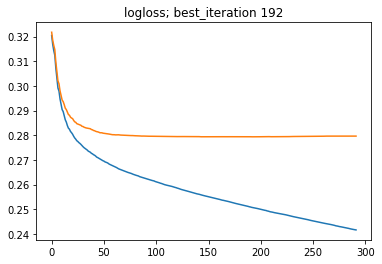

In [21]:
plt.plot(evalres['tr']['binary_logloss'])
plt.plot(evalres['vl']['binary_logloss'])
plt.title(f"logloss; best_iteration {bst.best_iteration}")
plt.show()

## model features

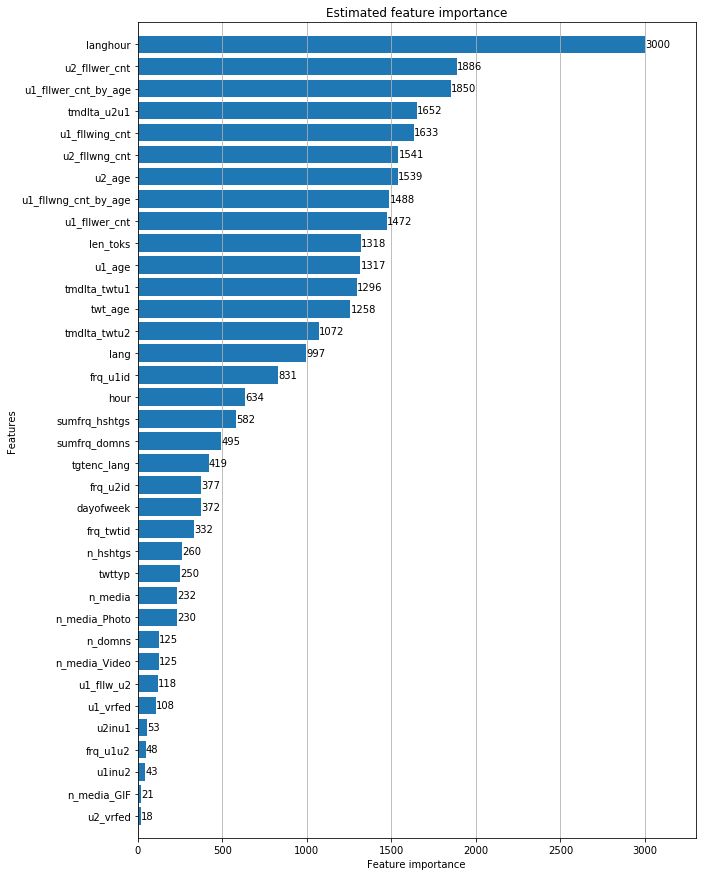

In [22]:
ax = lgb.plot_importance(bst, height=0.8, max_num_features=50, figsize=(10,15))
ax.grid(False, axis="y")
ax.set_title(f'Estimated feature importance')
plt.show()

In [23]:
pd.DataFrame([bst.feature_name(), bst.feature_importance()]).T.sort_values(1, ascending=False)

,0,1
28,langhour,3000
5,u2_fllwer_cnt,1886
26,u1_fllwer_cnt_by_age,1850
20,tmdlta_u2u1,1652
3,u1_fllwing_cnt,1633
6,u2_fllwng_cnt,1541
25,u2_age,1539
27,u1_fllwng_cnt_by_age,1488
2,u1_fllwer_cnt,1472
11,len_toks,1318


In [24]:
col2imp = dict(zip(bst.feature_name(), bst.feature_importance()))
sorted(col2imp.items(), key=lambda x: -x[1])

[('langhour', 3000),
 ('u2_fllwer_cnt', 1886),
 ('u1_fllwer_cnt_by_age', 1850),
 ('tmdlta_u2u1', 1652),
 ('u1_fllwing_cnt', 1633),
 ('u2_fllwng_cnt', 1541),
 ('u2_age', 1539),
 ('u1_fllwng_cnt_by_age', 1488),
 ('u1_fllwer_cnt', 1472),
 ('len_toks', 1318),
 ('u1_age', 1317),
 ('tmdlta_twtu1', 1296),
 ('twt_age', 1258),
 ('tmdlta_twtu2', 1072),
 ('lang', 997),
 ('frq_u1id', 831),
 ('hour', 634),
 ('sumfrq_hshtgs', 582),
 ('sumfrq_domns', 495),
 ('tgtenc_lang', 419),
 ('frq_u2id', 377),
 ('dayofweek', 372),
 ('frq_twtid', 332),
 ('n_hshtgs', 260),
 ('twttyp', 250),
 ('n_media', 232),
 ('n_media_Photo', 230),
 ('n_media_Video', 125),
 ('n_domns', 125),
 ('u1_fllw_u2', 118),
 ('u1_vrfed', 108),
 ('u2inu1', 53),
 ('frq_u1u2', 48),
 ('u1inu2', 43),
 ('n_media_GIF', 21),
 ('u2_vrfed', 18)]

In [25]:
[o[0] for o in sorted(col2imp.items(), key=lambda x: -x[1]) if o[1]>0]

['langhour',
 'u2_fllwer_cnt',
 'u1_fllwer_cnt_by_age',
 'tmdlta_u2u1',
 'u1_fllwing_cnt',
 'u2_fllwng_cnt',
 'u2_age',
 'u1_fllwng_cnt_by_age',
 'u1_fllwer_cnt',
 'len_toks',
 'u1_age',
 'tmdlta_twtu1',
 'twt_age',
 'tmdlta_twtu2',
 'lang',
 'frq_u1id',
 'hour',
 'sumfrq_hshtgs',
 'sumfrq_domns',
 'tgtenc_lang',
 'frq_u2id',
 'dayofweek',
 'frq_twtid',
 'n_hshtgs',
 'twttyp',
 'n_media',
 'n_media_Photo',
 'n_media_Video',
 'n_domns',
 'u1_fllw_u2',
 'u1_vrfed',
 'u2inu1',
 'frq_u1u2',
 'u1inu2',
 'n_media_GIF',
 'u2_vrfed']

# eval

In [26]:
%%time
prdtr = bst.predict(dftr[cols_feat],num_iteration=bst.best_iteration)
prdvl = bst.predict(dfvl[cols_feat],num_iteration=bst.best_iteration)
prdval0 = bst.predict(dfval[cols_feat],num_iteration=bst.best_iteration)
prdval = calibration(prdval0, train_pop, target_pop, sampled_train_pop, sampled_target_pop)

CPU times: user 1min 52s, sys: 9.13 s, total: 2min 1s
Wall time: 14.3 s


In [27]:
%%time
ytr,yvl,yval=[df[TCOL].values for df in (dftr,dfvl,dfval)]

auc_tr=compute_prauc(prdtr, ytr)
rce_tr=compute_rce(prdtr, ytr)
auc_vl=compute_prauc(prdvl, yvl)
rce_vl=compute_rce(prdvl, yvl)
auc_val=compute_prauc(prdval, yval)
rce_val=compute_rce(prdval, yval)

results['scrs'] = {}
results['scrs']['auc_tr']=auc_tr
results['scrs']['rce_tr']=rce_tr
results['scrs']['auc_vl']=auc_vl
results['scrs']['rce_vl']=rce_vl
results['scrs']['auc_val']=auc_val
results['scrs']['rce_val']=rce_val

CPU times: user 6.38 s, sys: 223 ms, total: 6.6 s
Wall time: 6.33 s


In [28]:
print(f'auc_tr:  {auc_tr:.4f}')
print(f'auc_vl:  {auc_vl:.4f}')
print(f'auc_val: {auc_val:.4f}')
print()
print(f'rce_tr:  {rce_tr:.4f}')
print(f'rce_vl:  {rce_vl:.4f}')
print(f'rce_val: {rce_val:.4f}')

auc_tr:  0.4241
auc_vl:  0.3046
auc_val: 0.1046

rce_tr:  23.6128
rce_vl:  15.2037
rce_val: 11.7583


## score

In [29]:
print(f'-{auc_val:.4f}-{rce_val:.4f}')

-0.1046-11.7583


# save results

In [30]:
pickle.dump(results, open(f'{p_out}/results_{PRFX}.p', 'wb'))

# infer

In [31]:
results = pickle.load( open(f'{p_out}/results_{PRFX}.p', 'rb'))
bst = results['bst']
col2tgtenc = results['col2tgtenc']
cols_feat = results['cols_feat']
tgt_encoder = results['tgt_encoder']

## prep

In [32]:
%%time
dftst=pd.read_csv(
    f'{p_in}/val_{tsttmstmp}.tsv',
    sep='\x01', header=None, names=cols_val, 
    nrows=10
)

CPU times: user 3.37 ms, sys: 3.8 ms, total: 7.17 ms
Wall time: 6.04 ms


In [33]:
%%time
dftst=prp_df(dftst, tm_max=tm_tst_max)

2020-04-11 22:27:38 start
2020-04-11 22:27:38 freq of columns using CountEncoder


/data/anaconda3/envs/rcss20/lib/python3.7/site-packages/category_encoders/count.py:255: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  X.loc[:, self.cols] = X.fillna(value=pd.np.nan)


2020-04-11 22:27:38 freq of tags
2020-04-11 22:27:38 done
CPU times: user 133 ms, sys: 7.39 ms, total: 141 ms
Wall time: 134 ms


In [34]:
encoded_tst = tgt_encoder.transform(dftst[col2tgtenc].astype(object))
tgtenc_columns = [f'tgtenc_{col}' for col in encoded_tst.columns]
encoded_tst.columns = tgtenc_columns
dftst = pd.concat([dftst, encoded_tst], 1)
dftst.drop(columns=['u1id','u1u2'], inplace=True)
cols_category=['twttyp', 'lang', 'langhour']
dftst[cols_category]=dftst[cols_category].astype('category')

## predict

In [35]:
%%time
prdtst0 = bst.predict(dftst[cols_feat],num_iteration=bst.best_iteration)
prdtst = calibration(prdtst0, train_pop, target_pop, sampled_train_pop, sampled_target_pop)

CPU times: user 9.91 ms, sys: 46.2 ms, total: 56.1 ms
Wall time: 22.8 ms


In [36]:
dfsub_ids = dftst[['twtid','u2id',]]
dfsub = dfsub_ids.copy()
dfsub['scr'] = prdtst
dfsub.to_csv(f'{p_out}/{TGT}__{PRFX}.csv',index=False,header=False)